### Step1 데이터 수집하기

In [1]:
import nltk
nltk.download('stopwords')

import tensorflow as tf
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

[nltk_data] Downloading package stopwords to /home/ssac8/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import pandas as pd
import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
33605,"Iyer slams 10 sixes, hits 93*(40) in 1st match...",Batting in his first match as the captain of D...
89156,Fans will see my romance with Anjali: Sachin o...,Sachin Tendulkar has said that the story of hi...
41400,4 killed in hailstorm at Andhra temple ahead o...,Four devotees were killed and over 50 injured ...
67305,"Rolls-Royce plunges into sinkhole, driver esca...",A 5 million yuan (nearly Ã¢ÂÂ¹5 crore) Rolls-...
54665,Ratan Tata rejected job offer at IBM to work a...,"Ratan Tata, who turns 80 today, rejected a job..."
33591,"Whale shark swims 20,000 km in 500 days in rec...","A whale shark, the world's largest living fish..."
38233,"'Mullah Radio', man behind attack on Malala ki...","Pakistani Taliban chief Maulana Fazlullah, als..."
8935,"Instagram testing new layouts, may put profile...",Facebook-owned photo-sharing app Instagram has...
92798,US Facebook murderer kills himself after polic...,"Steve Stephens, who was wanted by police for s..."
59281,Gopi Thonakal 1st Indian man to win Asian Mara...,Gopi Thonakal became the first Indian man to w...


### Step 2. 데이터 전처리 하기 (추상적 요약)    
* 필요한 전처리 추가 사용 및 텍스트 정규화   
* 짧은 문장에 대한 불용어 제거 선택 해보기   


In [4]:
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


In [5]:
#중복 샘플 제거하기 
data.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98360


In [6]:
#중복 샘플 제거하면서 생긴 null값 확인 해보기 
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


Null 값이 없음으로 나옴으로 다음으로 이동! 

#### 텍스트 정규화  
같은 의미인데도 다른 표현으로 쓰여 다치 다른 단어들 처럼 간주 되는 단어들 하나로 통일 시켜주기!   
-> 연산량을 줄여줌 --> 이것이 바로 텍스트 정규화 (text normalization)    


In [7]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


#### 불용어 제거    
텍스트에는 자주 등장하지만 자연어 처리시 실질적으로 별 도움 되지 않는 아이들을 stopwrods (불용어)라고 부름   
-> 불용어를 제거함으로써 자연어 처리 성능을 높일 수 있음.   
NLTK 제공하는 불용어 리스트 참조해서 불용어 제거 가능   


In [8]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

* 총 170개의 불용어가 나옴. 이 불용어들을 제거할거임.    
* 영어 문자 -> 소문자화   
* 섞여있는 html 태그 제거   
* 정규 표현식을 통해 각종 특수 문자 제거   


In [9]:
#데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

If 절로 True or False로 불용어 제거 및 미제거 선택 가능! 

In [10]:
#불용어 및 위에 언급되는 바가 잘 작동하는지 확인 해보기  
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


#####  뉴스 데이터를 보면 headlines이 대부분 text의 요약 버전이므로, 길이가 더 짧음.   
##### 그래서 headlines은 불용어 제거를 안하고, text만 불용어 제거를 해주겠음.    

In [11]:
#데이터 샘플 1개 다시 뽑아보기 
data.sample(1)

,headlines,text
98108,Thailand organises buffet for elephants to mar...,Dozens of elephants were treated to a fruit bu...


In [12]:
clean_headlines = []

# 전체 headlines 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False)) #headlines은 불용어제거 수행하지 않으니 False로 처리 

# 전처리 후 출력
clean_headlines[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

In [13]:
clean_text = []

# 전체 text 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s, False))

clean_text[:5]

['saurav kant an alumnus of upgrad and iiit pg program in machine learning and artificial intelligence was sr systems engineer at infosys with almost years of work experience the program and upgrad degree career support helped him transition to data scientist at tech mahindra with salary hike upgrad online power learning has powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance to win free food from swiggy for one year pranav kaushik delhi techie bagged this reward after spending cred coins users get one cred coin per rupee of bill paid which can be used to avail rewards from brands like ixigo bookmyshow ubereats cult fit and more',
 'new zealand defeated india by wickets in the fourth odi at hamilton on thursday to win their first match of the five match odi series india lost an international match under rohit sharma captaincy after consecutive victories dating back to march the match witnessed india getting all out for their seventh lowest total

오... 이렇게 마음에 드는 결과는 정말 오랜만에 봄.. ㅎㅎㅎ 뿌듯하구만

In [14]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

#### 샘플의 최대 길이 정하기    
필요 없는 단어들을 필터링 해놓은 상태에서, 훈련에서 사용할 샘플의 최대 길이 정해주기   


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 91
텍스트의 평균 길이 : 58.23813542090281
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 18
헤드라인의 평균 길이 : 9.553660024400163


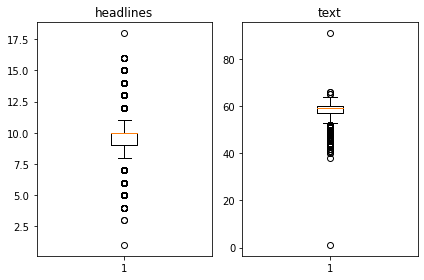

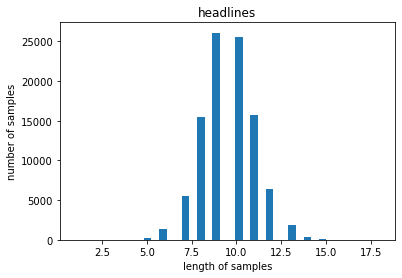

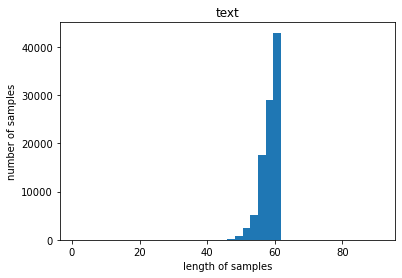

In [15]:
# headlines & text의 최소 & 최대, 평균 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [16]:
#headlines 과 text의 최대 길이 임의로 정해보기 
text_max_len = 75
headlines_max_len = 50
#heaadlines길이가 생각보다 긴것 처럼 느껴져서 간단 명료하게 하기 위해 평균 보다 낮은 50으로 설정 

In [17]:
#위에 설정한 최대값 내에서 데이터의 몇 %를 포함하는지 함수 만들어서 확인 해보기 
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [18]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 75 이하인 샘플의 비율: 0.9999898332655551
전체 샘플 중 길이가 50 이하인 샘플의 비율: 1.0


text의 경우 99%의 내용을 가지고 있고, headlines의 경우 5%의 내용을 가져간다고 함.   

In [19]:
#정해진 길이에 맞춰 자르는 것이 아닌, 정해진 길이보다 길면 제외한느 방법으로 데이터 정제 ! 
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98359


#### 훈련데이터와 테스트데이터 나누기 

In [20]:
#요약 데이터에는 시작 토큰과 종료 토큰을 추가한다. 앞뒤로 sostoken & eostoken  추가 
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",sostoken upGrad learner switches to career in ...,upGrad learner switches to career in ML & Al w...
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...,sostoken Delhi techie wins free food from Swig...,Delhi techie wins free food from Swiggy for on...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,sostoken New Zealand end Rohit Sharma-led Indi...,New Zealand end Rohit Sharma-led India's 12-ma...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...",sostoken Aegon life iTerm insurance plan helps...,Aegon life iTerm insurance plan helps customer...
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...,"sostoken Have known Hirani for yrs, what if Me...","Have known Hirani for yrs, what if MeToo claim..."


In [21]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98359
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98261


In [22]:
#52열의 값이 text오류로 계속 떠서 삭제해줌 
data.drop(52)

,headlines,text,decoder_input,decoder_target
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",sostoken upGrad learner switches to career in ...,upGrad learner switches to career in ML & Al w...
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...,sostoken Delhi techie wins free food from Swig...,Delhi techie wins free food from Swiggy for on...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,sostoken New Zealand end Rohit Sharma-led Indi...,New Zealand end Rohit Sharma-led India's 12-ma...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...",sostoken Aegon life iTerm insurance plan helps...,Aegon life iTerm insurance plan helps customer...
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...,"sostoken Have known Hirani for yrs, what if Me...","Have known Hirani for yrs, what if MeToo claim..."
...,...,...,...,...
98396,CRPF jawan axed to death by Maoists in Chhatti...,A CRPF jawan was on Tuesday axed to death with...,sostoken CRPF jawan axed to death by Maoists i...,CRPF jawan axed to death by Maoists in Chhatti...
98397,First song from Sonakshi Sinha's 'Noor' titled...,"'Uff Yeh', the first song from the Sonakshi Si...",sostoken First song from Sonakshi Sinha's 'Noo...,First song from Sonakshi Sinha's 'Noor' titled...
98398,'The Matrix' film to get a reboot: Reports,"According to reports, a new version of the 199...",sostoken 'The Matrix' film to get a reboot: Re...,'The Matrix' film to get a reboot: Reports eos...
98399,Snoop Dogg aims gun at clown dressed as Trump ...,A new music video shows rapper Snoop Dogg aimi...,sostoken Snoop Dogg aims gun at clown dressed ...,Snoop Dogg aims gun at clown dressed as Trump ...


In [23]:
#각각 다시 Numpy 타입으로 저장 
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [24]:
#직접 훈련 데이터와 테스트 데이터 분리하기 
# encoder_input과 크키과 형태가 같은 순서가 섞인 정수 시퀀스 만들어주기 
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[11329 34070 70838 ... 60284 46798 37548]


In [25]:
#위의 정수 시퀀스를 이용해 다시 데이터의 샘플 순서 정의 해주기 
# 그러면 잘 섞인 샘플이 나옴! 
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [26]:
#8:2로 훈련 데이터와 테스트 데이터 분리해주기 
#20%인 0.2곱해서 20%를 설정 
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 19671


In [27]:
#위에 정의한 데이터의 갯수를 이용해서 전체 데이터 양분하기 

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19671
테스트 레이블의 개수 : 19671


#### 단어 집합 (vocabulary) 만들기 및 정수 인코딩   
기계가 텍스트를 숫자 처리 할 수 있도록 훈련데이터와 테스트 데이터의 단어들을 모두 정수로 바꿔 줘야함.   
각 단어에 고유한 정수를 맵핑하는 작업이 필요.  --> 이것이 바로 단어 집합 (vocabulary) 만든다고 함.  


In [28]:
#keras tokenizer로 입력된 훈련 데이터로 단어 집합 만들 수 있긔 

src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

이제 생성된 단어 집합은 src_tokenizer.word_index에 저장 되어있음.   
여기서 빈도수가 낮은 훈련데이터는 제외해서 진행할거임.   
   
    등장 빈도수가 7회 미만인 데이터들의 비중이 얼마인지 확인 해보기    
    * src_tokenizer.word_counts.items() 는 단어와 각 단어 빈도수가 저장 되어 있어서 통게적인 정보 얻을 수 있음 

In [29]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 90950
등장 빈도가 6번 이하인 희귀 단어의 수: 66212
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 24738
단어 집합에서 희귀 단어의 비율: 72.80043980208906
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.7215755345213246


희귀 단어가 82%나 차지하고 있으므로, 확실히 희귀단어를 정리해주면 처리 성능이 좋아질 것으로 보임 

In [30]:
#집합의 크기 3900개로 제한 
src_vocab = 3900
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

*texts_to_sequences()는 생성된 단어 집합에 기반해서 주어진 텍스트 데이터의 단어를 모두 정수로 변환해주는 정수 인코딩임.    
3900개로 했으니까 이후에는 3900개가 숫자들은 데이터에 존재하지 않을 예정. 

In [31]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[206, 18, 3, 1794, 12, 191, 7, 30, 386, 2, 313, 4, 88, 49, 26, 154, 30, 592, 6, 17, 814, 1736, 1961, 9, 112, 622, 30, 191, 9, 45, 1108, 1, 49, 10, 56, 1363, 1, 754, 33, 2952, 1061, 5, 30, 3318, 372, 12, 40, 154, 9, 17, 185, 2567], [159, 1918, 3271, 5, 1, 88, 49, 26, 966, 252, 495, 4, 210, 487, 4, 616, 3241, 1, 887, 415, 6, 62, 5, 94, 597, 236, 301, 134, 1977, 2, 1078, 24, 102, 1, 44, 40, 3419, 91, 743, 334, 6, 355, 270, 323], [128, 338, 68, 3058, 147, 2, 1, 5, 771, 7, 157, 681, 9, 3, 5, 1, 1978, 385, 2, 734, 1, 1186, 286, 2626, 2, 626, 2918, 33, 36, 52, 44, 591, 2, 621, 2357, 41, 2000, 2, 36, 145, 6, 2626, 303, 2, 870, 21, 3, 625, 4, 1, 10]]


이젠 내가 무서워하는 숫자들만 나온다.. 
##### headlines에도 똑같이 정수로 모두 변경 해주고, decoder_input_train 입력해서 전체 단어 집합과 각 단어에 대한 빈도수 계산 해주기


In [32]:
#Tokenizer로 word Vocabulary 만들어주기 
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [33]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 40710
등장 빈도가 5번 이하인 희귀 단어의 수: 29368
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 11342
단어 집합에서 희귀 단어의 비율: 72.13952345860967
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.1092254026663095


In [34]:
#위에 희귀 단어 제외 후 단어 집합의 크기가 4141이니까 4100개로 맞춰줄거임 

tar_vocab = 4100
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 30, 973, 389, 146, 7, 835, 3, 196, 453, 880, 131], [1, 1191, 30, 361, 943, 368, 4, 234], [1, 3008, 832, 4, 561, 2535, 14], [1, 21, 105, 754, 314, 102, 527, 5, 165, 310, 2115], [1, 310, 139, 256, 355, 17, 3848, 410, 541]]
target
decoder  [[30, 973, 389, 146, 7, 835, 3, 196, 453, 880, 131, 2], [1191, 30, 361, 943, 368, 4, 234, 2], [3008, 832, 4, 561, 2535, 14, 2], [21, 105, 754, 314, 102, 527, 5, 165, 310, 2115, 2], [310, 139, 256, 355, 17, 3848, 410, 541, 2]]


In [35]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 4
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 78684
훈련 레이블의 개수 : 78684
테스트 데이터의 개수 : 19670
테스트 레이블의 개수 : 19670


/home/ssac8/anaconda3/envs/aiffel/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


#### 패딩하기 
서로 다른 길이의 샘플들을 병렬 처리 하기 위해 같은 길이로 맞춰주는 패딩 작업 

In [36]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = headlines_max_len, padding='post')

-----

### 모델 설계하기 

In [37]:
#함수형 API를 이용한 인코더 설계

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

인코더의 LSTM은 총 3개의 층으로 구성해서 모델의 복잡도를 높임.    
3개의 층을 지나서 인코더로 부터 나온 출력 벡터를 디코더로 보내줌.   


In [38]:
# 디코더 설계

decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [39]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 75)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 75, 128)      499200      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 75, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

현재까지 해준 것은 hidden state와 cell state를 디코더의 초기 state로 사용하는 가장 기본적인 seq2seq.    


-----

### Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)     
   * 일반적인 seq2seq 말고 어텐션 메커니즘 사용한 seq2seq 사용해보기   


In [40]:
#깃허브에 공개 돼 있는 어텐션 함수 다운로드 
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [41]:
#이전 설계한 디코드 출력층 아래와 같이 수정하기 

# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 75)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 75, 128)      499200      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 75, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### 모델 훈련하기 

In [44]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
308/308 [==============================] - 240s 779ms/step - loss: 0.7280 - val_loss: 0.7722
Epoch 2/50
308/308 [==============================] - 243s 790ms/step - loss: 0.7080 - val_loss: 0.7668
Epoch 3/50
308/308 [==============================] - 248s 804ms/step - loss: 0.6921 - val_loss: 0.7540
Epoch 4/50
308/308 [==============================] - 250s 812ms/step - loss: 0.6780 - val_loss: 0.7480
Epoch 5/50
308/308 [==============================] - 249s 809ms/step - loss: 0.6651 - val_loss: 0.7434
Epoch 6/50
308/308 [==============================] - 248s 804ms/step - loss: 0.6533 - val_loss: 0.7380
Epoch 7/50
308/308 [==============================] - 247s 801ms/step - loss: 0.6420 - val_loss: 0.7336
Epoch 8/50
308/308 [==============================] - 247s 802ms/step - loss: 0.6318 - val_loss: 0.7291
Epoch 9/50
308/308 [==============================] - 243s 789ms/step - loss: 0.6223 - val_loss: 0.7282
Epoch 10/50
308/308 [==============================] - 244s 791m

EarlyStopping은 조기 종료로, 특정 조건이 충족되면 모델의 훈련 멈추는 역할 함.    
여기서는 val_loss에서 patiensce = 2, 2회 관측 되면 멈추도록 설정 함    

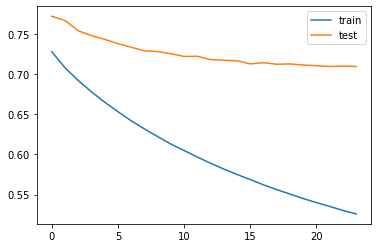

In [45]:
#훈련 데이터의 손실과 검증 데이터의 손실이 즐어드는 과정 시각화   

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 인퍼런스 모델 구현하기 

In [68]:
#테스트 단계에서는 정수 인덱스를 텍스트 데이터로 다시 복원해야함.   
#그래서 3개의 사전을 아래와 같이 준비! 
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

(참고) seq2seq는 훈련할 때와 실제 동작할때 (인퍼런스 단계)의 방식이 다르므로,   
그에 맞게 모델 설계를 별개로 진행해야함.   
   
   인코더 모델과 디코더 모델을 분리해서 설계 


In [69]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [70]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [71]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

### 모델 테스트하기   

In [72]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

### Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)   
* 원래의 요약문과 학습을 통해 얻은 추상적 요약의 결과 비교 해보기   

In [73]:
for i in range(1, 50):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : the us defence department has released a drone footage showing us troops trying to escape a militant in last year a total of 46 us and troops were by more than 100 isis outside the village of five troops and four us special forces were killed in the 
실제 요약 : video us troops try to escape militant in 
예측 요약 :  us military drone used to us army base


원문 : the election commission is likely to hold assembly elections in andhra pradesh odisha and pradesh with the 2019 lok sabha elections reports said elections in jammu and kashmir may also be held alongside general elections or before that an official said the commission is bound to hold elections in j k within six months after the assembly is 
실제 요약 : elections in 4 states may be held with 2019 ls polls report 
예측 요약 :  ec to contest polls in j k amid election results


원문 : a has claimed that forward and premier top injury in the champions league final is punishment for breaking his fast the further said that the injury suffered by 

예측 요약 :  govt plans to use govt to build govt land alliance with


원문 : virat kohli has become the first player to win all three major annual icc awards in a single year for his in 2018 kohli was named men's test player of the year for the first time while he also won cricketer and odi player of year awards he was also named captain of test and odi teams of 2018 
실제 요약 : kohli first player to win all three top icc awards in single year 
예측 요약 :  kohli becomes 1st ever player to win top int'l cricketer award


원문 : a poster showing telangana chief minister rao as lord ram was put up in reddy district ahead of the ruling telangana rally on sunday around 25 lakh people are expected to attend the rally amid reports that rao may the of telangana assembly and call for early elections 
실제 요약 : poster of telangana cm as lord ram put up ahead of rally 
예측 요약 :  poster of jd u 17 dalit in telangana


원문 : the advertising standards council of india has found advertisements of companies including 

예측 요약 :  gayle gayle sets record for most in ipl


원문 : a 35 year old man off his sister in head and hands for by her in delhi's on friday the man to her sense of lack of in talking to other men and suspected her of having officials said the accused then by claiming that he did the right thing 
실제 요약 : delhi man sister in law for honour 
예측 요약 :  delhi man off sister after being stabbed by


원문 : former rbi governor when asked about elected has said it's often people to a certain of society who take countries down the wrong path warning that policies out of damage economic growth he said the short term political solutions to concerns about job could the of the country 
실제 요약 : elected can take nations down wrong rajan 
예측 요약 :  rajan praises rajan for speech


원문 : the trailer of ayushmann and starrer has been released ayushmann plays the role of a player while plays his love interest in the film directed by the film is scheduled to release on october 5 will mark the first of with ayus

### Step 5. Summa를 이용해서 추출적 요약해보기    
추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 Summa의 추출적 요약 사용해보기  


1) 패키지 설치 필요   

$ pip install summa


In [59]:
#데이터 다운로드하기 
import requests
from summa.summarizer import summarize

In [60]:
#메트릭스 시놉시스 다운로드 하기 
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

In [61]:
#시놉시스 다운로드 후, 일부 출력해보기 (문자열로 저장 되어 있음)
print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

#### Summarize 사용하기 

< Summa의 Summarize()의 인자로 사용되는 값들 >   

* text (str) : 요약할 테스트.   

* ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값   

* words (int or None, optional) – 출력에 포함할 단어 수.   

만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.   

* split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환   
   
 <특징: Summa의 summarize는 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행해요. 그렇기 때문에 문장 구분이 되어있지 않은 원문을 바로 입력으로 넣을 수 있어요> 

In [99]:
# 원문의 0.005%만 요약해서 출력하는 방법
print('Summary:')
print(summarize(text, ratio=0.005))

Summary:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


In [101]:
#리스트로 결과 출력 받기 
# split 인자 값을 True로 하면 됨!
print('Summary:')
print(summarize(text, ratio=0.005, split=True))

Summary:
['Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.', 'Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.']


In [102]:
#단어의 수로 요약문 크기 조절하기 
#단어 50개만 선택해서 요약하기 
print('Summary:')
print(summarize(text, words=50))

Summary:
Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


---

위에 csv의 뉴스를 summa로 해보고 싶은데, 도저히 str으로 변경하는 방법을 모르겠어서   
그냥 매트릭스 시놉시스로 진행하였습니다 ㅠㅠ    

BBC에서 뉴스 하나 뽑아서 txt로 넣어봤는데도, Readable하지 않다고 떠서 summa는 다른 파일에 사용하지 못하였습니다 ㅠㅠ   
혹시나 방법 있다면 공유 부탁 드려용   
